In [78]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

In [79]:
df = pd.read_csv('../data/local_data/merged_cleaned_data.csv')
display(df.head())

,Census Section,District,Date,Use,Number of Meters,Accumulated Consumption,Max Temperature,Min Temperature,Precipitation,Tourist Accommodations,Hotel Overnight Stays
0,801901001,1,2021-01-01,Commercial,56,2710,7.55,4.30,5.65,1775.0,4411
1,801901001,1,2021-01-01,Domestic,322,10058,7.55,4.30,5.65,1775.0,4411
2,801901001,1,2021-01-01,Industrial,10,140646,7.55,4.30,5.65,1775.0,4411
3,801901001,1,2021-01-02,Commercial,56,3573,8.55,1.55,0.00,4646.0,11547
4,801901001,1,2021-01-02,Domestic,322,9600,8.55,1.55,0.00,4646.0,11547


In [80]:
# Assuming we don't wanna work by differenciating the use column
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Aggregate data by Census Section and Date. We ignore the district info since it is not relevant at all
# Another alternative would be to do the grouping by District and Date, but thus leaving to less datapoints
df_census = df.groupby(['Census Section', 'Date']).agg({
    'Accumulated Consumption': 'sum',
    'Number of Meters': 'sum',
    'Max Temperature': 'mean',
    'Min Temperature': 'mean',
    'Precipitation': 'mean',
    'Tourist Accommodations': 'mean',
    'Hotel Overnight Stays': 'mean'
}).reset_index()

In [81]:
display(df_census.head())

,Census Section,Date,Accumulated Consumption,Number of Meters,Max Temperature,Min Temperature,Precipitation,Tourist Accommodations,Hotel Overnight Stays
0,801901001,2021-01-01,153414,388,7.55,4.30,5.65,1775.0,4411.0
1,801901001,2021-01-02,166201,388,8.55,1.55,0.00,4646.0,11547.0
2,801901001,2021-01-03,129309,388,9.55,0.85,0.00,3151.0,7833.0
3,801901001,2021-01-04,141909,387,10.10,0.65,0.00,4337.0,10778.0
4,801901001,2021-01-05,137782,387,9.40,0.65,0.00,4580.0,11382.0


In [82]:
# Use the census section 801901001 as an example
n = 90
df_sample = df_census[df_census["Census Section" ] == 801901001].drop("Census Section", axis=1)
df_sample_reduced = df_sample.iloc[:-n]
display(df_sample.head())

,Date,Accumulated Consumption,Number of Meters,Max Temperature,Min Temperature,Precipitation,Tourist Accommodations,Hotel Overnight Stays
0,2021-01-01,153414,388,7.55,4.30,5.65,1775.0,4411.0
1,2021-01-02,166201,388,8.55,1.55,0.00,4646.0,11547.0
2,2021-01-03,129309,388,9.55,0.85,0.00,3151.0,7833.0
3,2021-01-04,141909,387,10.10,0.65,0.00,4337.0,10778.0
4,2021-01-05,137782,387,9.40,0.65,0.00,4580.0,11382.0


In [83]:
df_prophet = df_sample_reduced.rename(columns={'Date': 'ds', 'Accumulated Consumption': 'y'})
model = Prophet()

model.add_regressor('Number of Meters')
model.add_regressor('Max Temperature')
model.add_regressor('Min Temperature')
model.add_regressor('Precipitation')
model.add_regressor('Tourist Accommodations')
model.add_regressor('Hotel Overnight Stays')


model.fit(df_prophet)

02:36:48 - cmdstanpy - INFO - Chain [1] start processing
02:36:48 - cmdstanpy - INFO - Chain [1] done processing


             ds           yhat     yhat_lower    yhat_upper
1090 2023-12-27  656777.924668  225756.951502  1.063425e+06
1091 2023-12-28  572546.014628  144639.756456  9.747440e+05
1092 2023-12-29  562842.473207  146804.368104  9.517835e+05
1093 2023-12-30  510287.856106   95127.502811  9.465571e+05
1094 2023-12-31  541983.027591  130234.520252  9.623879e+05


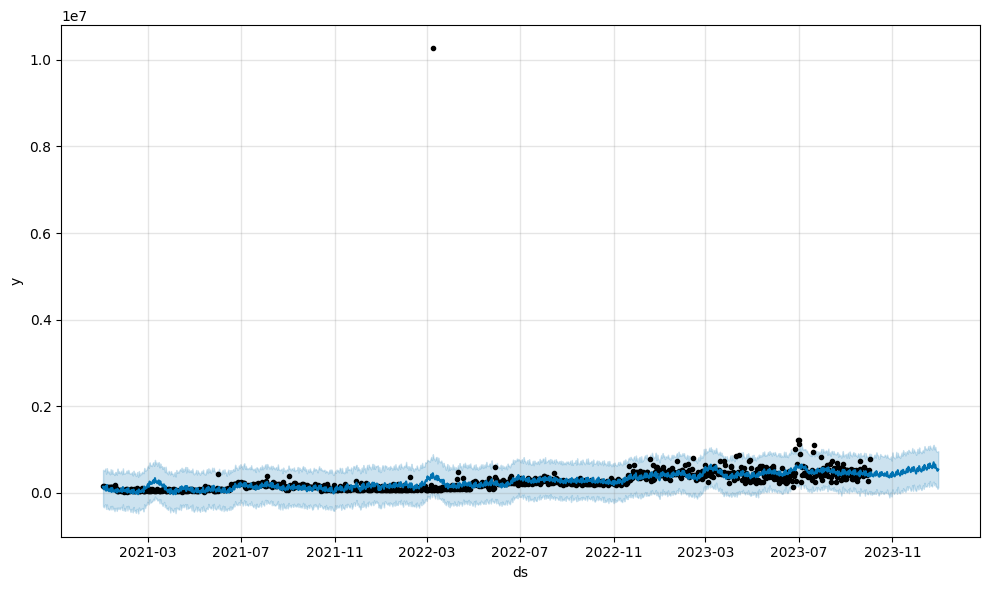

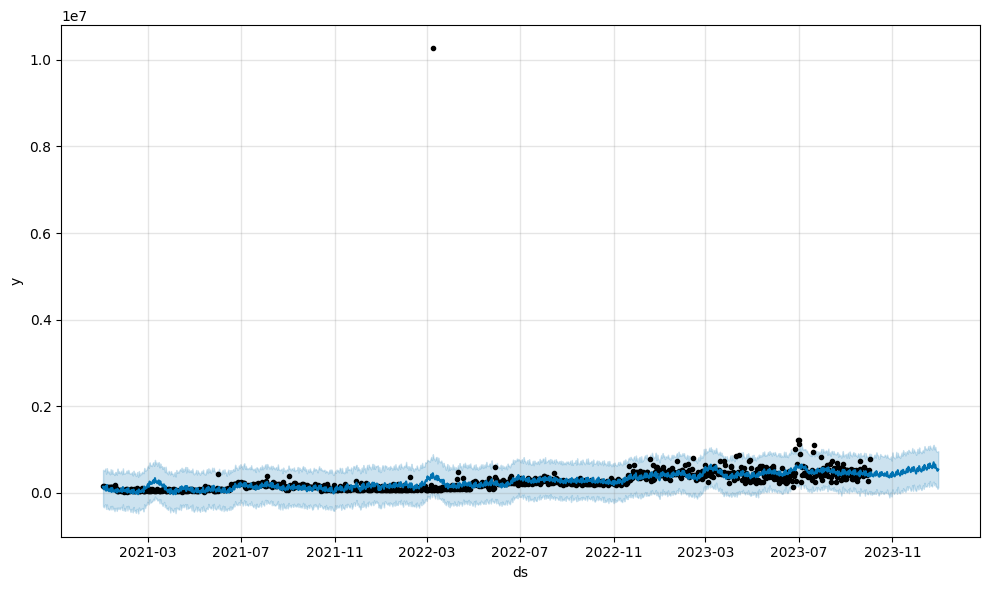

In [84]:
future = model.make_future_dataframe(periods=n)

# Add future values for the regressors (replace with actual future data)
future['Number of Meters'] = df_sample['Number of Meters'].tolist() 
future['Max Temperature'] = df_sample['Max Temperature'].tolist() 
future['Min Temperature'] = df_sample['Min Temperature'].tolist() 
future['Precipitation'] = df_sample['Precipitation'].tolist() 
future['Tourist Accommodations'] = df_sample['Tourist Accommodations'].tolist() 
future['Hotel Overnight Stays'] = df_sample['Hotel Overnight Stays'].tolist() 

forecast = model.predict(future)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


model.plot(forecast)

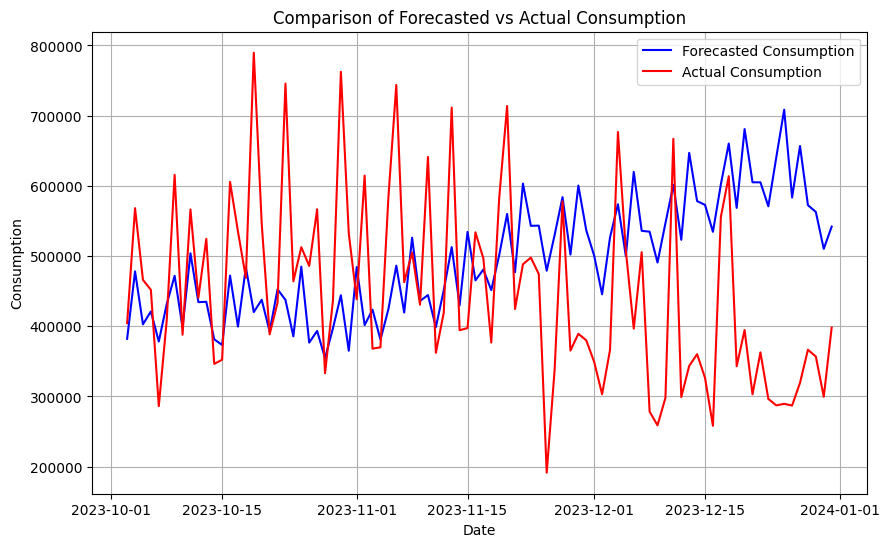

Mean Absolute Error (MAE): 136855.00072169717
Mean Squared Error (MSE): 29891391705.154114


In [85]:
# Step 1: Extract the last 90 days of forecasted values
forecast_last_90 = forecast[['ds', 'yhat']].tail(n)  # 'yhat' is the predicted value

# Step 2: Assuming 'df_actual' is the DataFrame with actual values for the last 90 days
# Make sure 'df_actual' has columns ['Date', 'Actual Consumption']
df_actual = df_sample.rename(columns={'Date': 'ds', 'Accumulated Consumption': 'y_actual'})[['ds', 'y_actual']]

# Step 3: Merge forecasted and actual values based on 'ds' (date)
comparison_df = pd.merge(forecast_last_90, df_actual[['ds', 'y_actual']], on='ds', how='inner')

# Step 4: Visualize the comparison
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['ds'], comparison_df['yhat'], label='Forecasted Consumption', color='blue')
plt.plot(comparison_df['ds'], comparison_df['y_actual'], label='Actual Consumption', color='red')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Comparison of Forecasted vs Actual Consumption')
plt.legend()
plt.grid(True)
plt.show()

# Step 5: Calculate error metrics (e.g., MAE, MSE)
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(comparison_df['y_actual'], comparison_df['yhat'])
mse = mean_squared_error(comparison_df['y_actual'], comparison_df['yhat'])

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-small",
  device_map="cuda",
  torch_dtype=torch.bfloat16,
)

df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(df["#Passengers"])
prediction_length = 12
forecast = pipeline.predict(context, prediction_length)  # shape [num_series, num_samples, prediction_length]

# visualize the forecast
forecast_index = range(len(df), len(df) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(df["#Passengers"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()


ImportError: cannot import name 'ChronosPipeline' from 'chronos' (/home/iv97n/Documents/drop-by-drop/.venv/lib/python3.11/site-packages/chronos/__init__.py)